<p>
    <strong>Idea</strong>: Combine <a href="https://arxiv.org/pdf/1802.03916.pdf">BBSE (Lipton et al ICML '18)</a> with <a href="https://arxiv.org/pdf/2007.08479.pdf">MALLS' (Zhao et al AISTATS '21)</a> subsampling technique while using <a href="http://proceedings.mlr.press/v70/finn17a/finn17a.pdf">MAML (Finn et al ICML '17)</a> to reduce bias in importance sampling weights learned from medial distribution and focus on domain adaptation on label shift.
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
import math
import time
from collections import Counter, deque, OrderedDict

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F

from model import Network

In [2]:
X, y = load_iris(return_X_y=True) #multiclassification

In [3]:
test_ratio = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)

## Create Imbalanced Dataset

In [4]:
def group_by_label(y):
    """ Groups data by label and returns indices per label """
    label_dict = {}
    for i in range(len(y)):
        if y[i] in label_dict:
            label_dict[y[i]].append(i)
        else: 
            label_dict[y[i]] = [i]
        
    return dict(OrderedDict(sorted(label_dict.items())))

In [5]:
idx_by_label = group_by_label(y_train) #label : [indices of all labels]

In [6]:
def dirichlet_distribution(alpha, idx_by_label, size):
    """ Create Imbalanced data using dirichlet distribution """
    distribution = np.random.dirichlet([alpha]*len(idx_by_label), size=())
    idx_by_label = idx_by_label.copy()
    #Group data by label
    for label in idx_by_label:
        class_size = math.ceil(size * distribution[label])
        if not class_size:
            class_size = 1 #min number to support A.2 assumption (BBSE ICML '18)
        indices = np.random.randint(0,
                                   len(idx_by_label[label]),
                                   size=(class_size, ))
        idx_by_label[label] = [idx_by_label[label][i] for i in indices]
    
    class_composition = np.array([len(idx_by_label[k]) for k in sorted(idx_by_label.keys())], np.int16)
    print("Class composition: ", class_composition)
        
    #Build new dataset
    dataset = []
    for v in idx_by_label.values():
        dataset += v
    return dataset #shifted distribution

In [7]:
train_ratio = 1
data_cap = int(X_train.shape[0])
size = int(data_cap * (train_ratio / (train_ratio + 1)))

In [8]:
shifted_dist_idx = dirichlet_distribution(alpha=0.1, idx_by_label=idx_by_label, size=size)

Class composition:  [ 1  1 52]


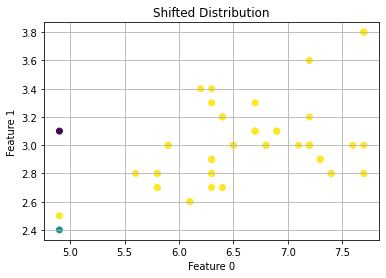

In [9]:
### Shifted Distribution
plt.scatter(X_train[shifted_dist_idx].T[0], X_train[shifted_dist_idx].T[1], c=y_train[shifted_dist_idx])
plt.title("Shifted Distribution")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.grid()
plt.show()

## Sync With Data

In [10]:
X_train, y_train = X_train[shifted_dist_idx], y_train[shifted_dist_idx]

In [11]:
def get_distribution(labels):
    """ Returns the distribution of classes as ratios """
    dist = dict(Counter(labels))
    total_size = 0
    for key, value in dist.items():
        total_size += value
    
    for key in dist:
        dist[key] /= total_size
        
    return dict(OrderedDict(sorted(dist.items())))

In [12]:
#Get source (train) and target (test) label distributions
dist_train = get_distribution(y_train)
dist_test  = get_distribution(y_test)

print(f"Train distribution : {dist_train}")
print(f"Test distribution : {dist_test}")

Train distribution : {0: 0.018518518518518517, 1: 0.018518518518518517, 2: 0.9629629629629629}
Test distribution : {0: 0.4222222222222222, 1: 0.28888888888888886, 2: 0.28888888888888886}


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

In [14]:
##typecast to tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [15]:
# implement backprop
loss_function = nn.CrossEntropyLoss()

In [16]:
def train(data, epochs=500, epsilon=1e-2, print_st=False):
    """
    Train the model.
    Assumes access to global variable: loss function
    """
    X_train, y_train = data #extract info
    
    start_time = time.time()
    losses = []

    model = Network().to(device) #load local model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    for i in range(epochs):
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss)
        
        if loss.item() < epsilon:
            if print_st:
                print(f"Model Converged at epoch {i + 1}, loss = {loss.item()}")
            break
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if print_st:
        print(f"Total training time (sec): {time.time() - start_time}, loss - {loss.item()}")

    return model, losses

In [17]:
model, cost = train((X_train, y_train), print_st=True)

Model Converged at epoch 194, loss = 0.009818621911108494
Total training time (sec): 0.20266318321228027, loss - 0.009818621911108494


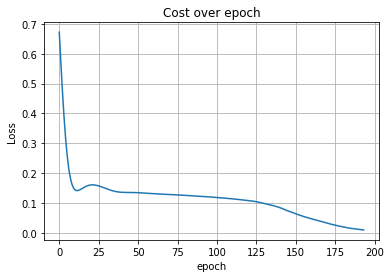

In [18]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Cost over epoch")
plt.grid()
plt.show()

### Test Model

In [19]:
def predict(model, traininig_points=0):
    """ Predict accuracy => y_hat = f(x). Refer to BBSE, ICML '18 """
    
    model.eval() #set to evaluation mode
    # predict X_test data
    predictions=[]
    with torch.no_grad():
        for i, data in enumerate(X_test):
            y_pred = model(data)
            predictions.append(y_pred.argmax().item())

    predictions = np.array(predictions, dtype=np.int16)
    score = accuracy_score(y_test, predictions)
    return score, predictions

In [20]:
### Estimated distribution
score, predictions = predict(model)
print(f"Test Accuracy : {score}")

Test Accuracy : 0.7555555555555555
